## 1. Подберите параметры алгоритма разрастания регионов так, чтобы был выделен весь участок газона

In [82]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

In [83]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

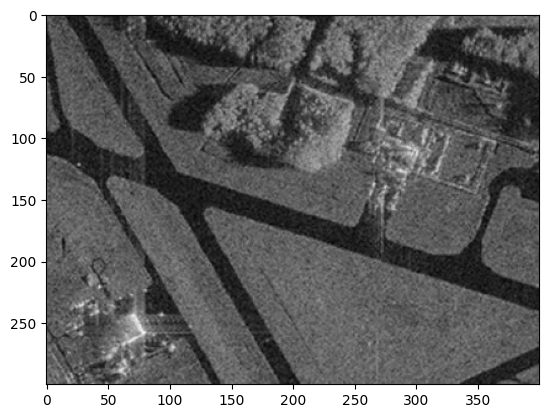

In [84]:
plt.imshow(image_gray, cmap="gray")

In [85]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
    if abs(av_val - img[point]) <= T:
        return True
    return False

In [86]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j +
                r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

In [87]:
seed_point = (250, 250)
mask = region_growing(image_gray, seed_point, homo_average, 5, 18)

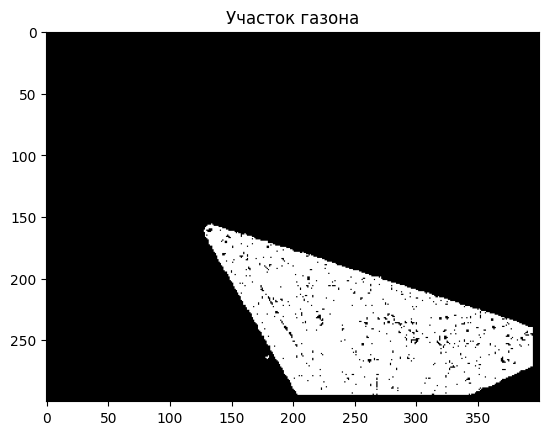

In [88]:
plt.imshow(mask, cmap="gray")
plt.title("Участок газона")
plt.show()

## 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты

In [89]:
flags = cv2.KMEANS_RANDOM_CENTERS
z = image_gray.reshape((-1,3))
z = np.float32(z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

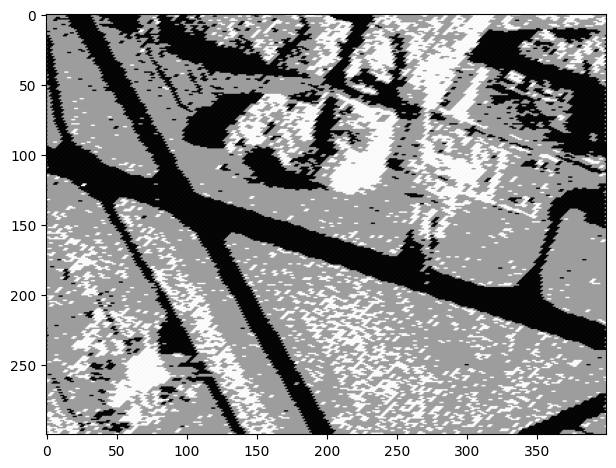

In [90]:
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.imshow(res2, cmap="gray")

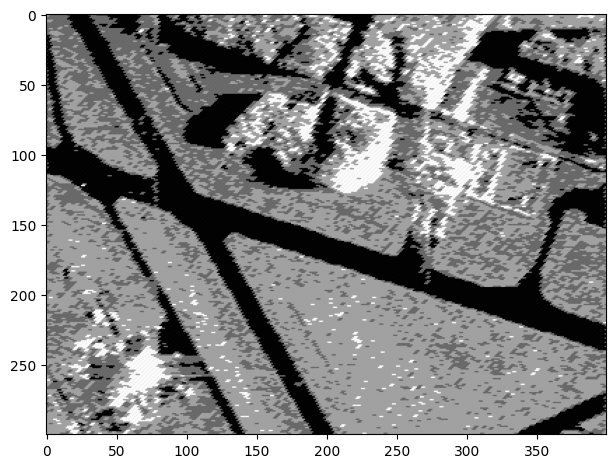

In [91]:
K = 4
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.imshow(res2, cmap="gray")

## Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев

In [92]:
image = cv2.imread("palm_1.JPG")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

(-0.5, 534.5, 526.5, -0.5)

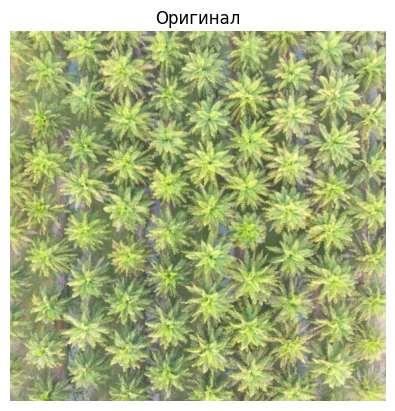

In [93]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Оригинал')
plt.axis('off')

In [94]:
blurred = cv2.GaussianBlur(image_gray, (13, 13), 0)
ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

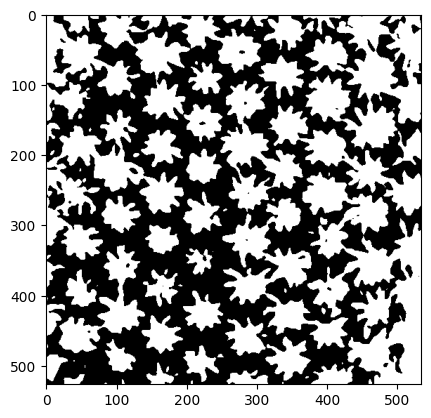

In [95]:
thresh_inverted = cv2.bitwise_not(thresh)

plt.imshow(thresh_inverted, cmap="gray")

In [96]:
dist_transform = cv2.distanceTransform(thresh_inverted, cv2.DIST_L2, 5)

In [97]:
local_maxima = ndimage.maximum_filter(dist_transform, size=20, mode='constant')

In [98]:
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg)
markers = cv2.watershed(image, markers.astype(np.int32))

In [99]:
num_palms = len(np.unique(markers)) - 1

In [100]:
segmented_image = image.copy()
segmented_image[markers == -1] = [255, 0, 255]

Пальмы: 43


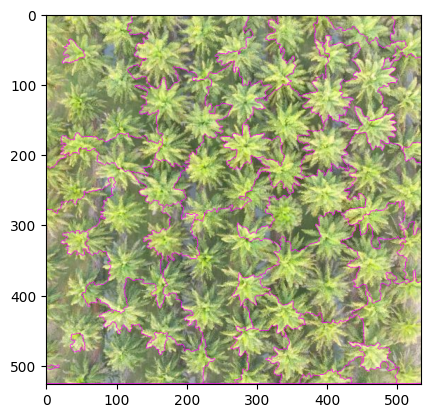

In [101]:
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
print("Пальмы:", num_palms)